![Image](./resources/header.png)
<h1 align="center">From Neural Variability to Population Coding</h1> 
<h3 align="center">TReND CaMinA 2024</h3>

<div style="background: #ADD8E6; border-radius: 3px; padding: 10px;">

In this notebook we're going to explore neural decoding, that is, how can we identify information contained in neural activities. Building on the concept of neural tuning curve, we will learn how to decode information about the stimuli presented. We will then discuss how to understand trial-to-trial neural response varibility and why decoding with population responses might give us more information compared to single neuron.

</div>

## Import & Brain Observatory Setup 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Brain Observatory Setup 
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.brain_observatory.drifting_gratings import DriftingGratings

manifest_file = '../data/allen-brain-observatory/visual-coding-2p/manifest.json'
boc = BrainObservatoryCache(manifest_file=manifest_file)

## If using hard drives

In [ ]:
import os
import platform

# Set file location based on platform. 
platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/TReND2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/TReND2024/"

In [ ]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = os.path.join(data_root,'allen-brain-observatory/visual-coding-2p/manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_file)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<h1> Part 1: Decoding stimulus direction from single neuron response</h1>

</div>

Yesterday we introduced the concept of a tuning curve, which is the mean response of a single neuron as a function of stimulus features (e.g. direction of drifting grating). We also learned how to compute and plot the tuning curve of a single neuron. 

Today we're interested in how can we decode stimulus features (e.g. direction of drifting grating) from single neuron responses on a trial-to-trial basis. In other words, can we tell what grating direction was presented in each trial by looking at the neural response in that trial?

Let's start from a quick review and see how tuning curve can help us decode stimulus direction.

In [3]:
cell_id = 541513979

# get the experiment session where this cell has the drifting grating stimulus
exps = boc.get_ophys_experiments(cell_specimen_ids=[cell_id], stimuli=['drifting_gratings'])
session_id = exps[0]['id']
data_set = boc.get_ophys_experiment_data(session_id)

# get trial-to-trial dff traces
timestamps, dff = data_set.get_dff_traces()
cell_index = data_set.get_cell_specimen_indices([cell_id])[0]
dff_trace = dff[cell_index,:]

In [ ]:
# get the stimulus table for the drifting grating stimulus
stim_table = ?
stim_table.head()

We also learned how to use `pandas` `DataFrame` to store intermediate data for further computation

In [ ]:
# create a pandas DataFrame to store the mean response of the neuron in each trial
response = pd.DataFrame(
    columns=('orientation', 'temporal_frequency', 'trial_response'), 
    index=stim_table.index.values
) 
# store orientation
response['orientation'] = ?
# store temporal_frequency
response['temporal_frequency'] = ?
# store mean trial response
for ind,row_stim in stim_table.iterrows():
    # mean DF/F during the grating presentation
    response.loc[ind, 'trial_response'] = ?

response.head()

In [ ]:
# plot grating response as a function of the grating direction
plt.plot(?)
plt.xlabel("Direction", fontsize=16)
plt.xticks(range(0,360,45))
plt.xlim(-10,325)
plt.ylabel("Mean DF/F", fontsize=16)

Now we compute the tuning curve for this neuron as a function of grating direction

In [ ]:
# tuning curve
# get all unique directions
all_ori = np.sort(stim_table.orientation.unique())
orivals = all_ori[np.isfinite(all_ori)]  # drop the nan trials
print(orivals)

# compute the mean and standard deviation of the responses for each unique direction
tuning = np.empty((8))
tuning_std = np.empty((8))
for i, ori in enumerate(orivals):
    trials = response[response.orientation==ori]
    tuning[i] = ?
    tuning_std[i] = ?
    

# plot the mean and std of the response for each direction
plt.errorbar(?)
plt.xlabel("Direction (deg)")
plt.xticks(range(0,360,45))
plt.ylabel("Mean response (DFF)")

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Take a look at the tuning curve of this neuron. How may we decode stimulus direction on a trial-to-trial basis by looking at the responses of this neuron?
</div>

The tuning curve tells us about what stimlus features drive the neuron. For example, this neuron responds most strongly to the 90-degree grating, somewhat strongly to the 270-degree grating, and only very weakly to the other directions. We can use this response profile to derive heuristic rules to decode grating directions on a trial-to-trial basis.

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Discuss** Please discuss how you might want to use tuning curve to decode stimulus direction.
</div>

In [ ]:
# decode using tuning curve: heuristics
# if mean DFF>1.0, classify as 90-degree
# if mean 0.1<DFF<1.0, classify as 270-degree
# if mean DFF<0.1, randomly classify as one of the rest


plt.errorbar(orivals, tuning, yerr=tuning_std, fmt='o-', zorder=0)
plt.xlabel("Direction (deg)")
plt.ylabel("Mean response (DFF)")

# if mean DFF>1.0, classify as 90-degree
plt.scatter(orivals[2], tuning[2], color='r')
plt.axhline(1.0, ls='--', color='r', 
           label='90: DFF>1.0', zorder=15)

# if mean 0.1<DFF<1.0, classify as 270-degree
plt.scatter(orivals[6], tuning[6], color='g')
plt.axhline(0.1, ls='--', color='g', 
           label='275: 0.1<DFF<1.0', zorder=10)

# if mean DFF<0.1, randomly classify as one of the rest
plt.scatter(orivals[[0,1,3,4,5,7]], tuning[[0,1,3,4,5,7]], color='k',
            label='DFF<0.1', zorder=5)
plt.xticks(range(0,360,45))

plt.legend()

Now let's apply this heuristic decoding to each trial and see how accurate this approach is. First, let's visualize the decoding result.

In [ ]:
# Plot the trial response for the first 15 trials, apply our heuristic decoding
num_trials = 15
selected_trial_response = response.trial_response[:num_trials]

# if mean DFF>1.0, classify as 90-degree
plt.axhline(1.0, ls='--', color='r', 
           label='90: DFF>1.0', zorder=15)
plt.plot(selected_trial_response[selected_trial_response>1.0], 
         'o', color='r')

# if mean 0.1<DFF<1.0, classify as 270-degree
plt.axhline(0.1, ls='--', color='g', 
           label='275: 0.1<DFF<1.0', zorder=10)
plt.plot(selected_trial_response[(selected_trial_response<1.0) & (selected_trial_response>0.1)], 
         'o', color='g')

# if mean DFF<0.1, randomly classify as one of the rest
plt.axhline(0.1, ls='--', color='k', 
           label='DFF<0.1', zorder=5)
plt.plot(selected_trial_response[selected_trial_response<0.1], 
         'o', color='k')

plt.xlabel("Trial number")
plt.ylabel("Mean DFF (%)")
plt.legend()

But how accurate this heuristic decoding using tuning curve is? Let's apply them to each trial and analyze its accuracy.

In [10]:
# implement heuristic decoding using tuning profile of the neuron
import random

ori_heuristic_cell1 = []
for trial_response in response.trial_response:
    if trial_response >= 1.0:
        # if mean DFF>1.0, classify as 90-degree
        ori_heuristic_cell1.append(90)
    elif (trial_response < 1.0 and trial_response>=0.1):
        # if mean 0.1<DFF<1.0, classify as 270-degree
        # ?
    else:
        # if mean DFF<0.1, randomly classify as one of the rest
        # ?

ori_heuristic_cell1 = np.array(ori_heuristic_cell1)

In [ ]:
# Let's visualize the deviation of our decoding from ground truth, for the first 15 trials
num_trials = 15

plt.scatter(np.arange(num_trials), stim_table.orientation.fillna(-45)[:num_trials], 
            color='r', label='ground truth', alpha=0.5)
plt.scatter(np.arange(num_trials), ori_heuristic_cell1[:num_trials], 
            color='b', label='decoding', s=20, alpha=0.5)

plt.xlabel('Trial number')
plt.xticks(range(0, num_trials, 1))
plt.ylabel('Direction (deg)')
plt.yticks(range(-45,360,45))

plt.grid()
plt.legend()

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Discuss** What are some issues with this heuristic approach of using tuning curve for decoding stimulus direction?
</div>

We can see from above that on some trials our heuristic decoding accurately decode the stimulus direction, but on other trials if fails. We can formally quantify the decoding accuracy using a metric called confusion matrix.

A confusion matrix calculates how frequent the decoded directions predicts the correct directions, and how often the decoding confuses one direction with another. It provides a complete summary and assessment of decoding performance.

To compute a confusion matrix, on the y-axis we have the true direction and on the x-axis we have the predicted direction using our heuristic decoding. Each cell in this matrix will document the number of times the corresponding true direction (e.g. 0 deg) is predicted as the corresponding predicted direction (e.g. 45 deg). Let's implement how this is done.

In [ ]:
# First we need to filter out and drop the nan trials
# we will use the pandas .notnull() method to create a mask to select trials with valid stimulus direction
print(stim_table.orientation.notnull())
not_nan_trials_mask = stim_table.orientation.notnull()

# filter the true directions and the predicted directions using the above mask
true_orientations = stim_table.orientation[not_nan_trials_mask]
predicted_orientations = ori_heuristic_cell1[not_nan_trials_mask]

In [ ]:
# convince yourself the above mask is doing what we want for dropping nan trials
# by printing the length of the raw arrays and the filtered array
# ?

In [ ]:
# construct confusion matrix
# start with an empty confusion matrix for filling out trial by trial
confusion_matrix = np.zeros((8,8)).astype(int)

# loop over each trial, and accumulate prediction result
for i, true_orientation in enumerate(true_orientations):
    true_class = int(true_orientation/ 45)
    
    predicted_orientation = predicted_orientations[i]
    predicted_class = int(predicted_orientation/ 45)

    # now we identiy the true class and predicted class for each trial
    # update the counts at the corresponding cell in the confusion matrix
    # ?

confusion_matrix

Let's visualize the above confusion matrix with the function `imshow`

In [ ]:
plt.imshow(confusion_matrix, interpolation='none')
plt.xlabel('Predicted direction')
plt.xticks(np.arange(8), np.arange(0,360,45))
plt.ylabel('True direction')
plt.yticks(np.arange(8), np.arange(0,360,45))
plt.colorbar()

Using confusion matrix, we can compute the accuracy (# correct decoding/ # total trials) of decoding very easily.

In [ ]:
# compute the accuracy
# ?

In fact, there is a very convenient function from scikit-learn that we can directly use!

In [ ]:
# compute confusion matrix using scikit-learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    true_orientations, 
    predicted_orientations)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=np.arange(0, 360, 45))
disp.plot()

We can normalize the confusion matrix by the total number of trials in each row (true direction) to derive the ratio of trials where the prediction is correct or incorrect

In [ ]:
# normalized confusion matrix
normalized_cm = cm/ ?
disp = ConfusionMatrixDisplay(confusion_matrix=normalized_cm, 
                              display_labels=np.arange(0, 360, 45))
disp.plot()

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Discuss** What does the above confusion matrix tell us how good we are at decoding stimulus orienation? Are there particular orientations that we can decode better? Why? And why can't we decode other orientations equally well? Even for the orientations that we have decent decodability, why doesn't it approach 100%?
</div>




<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Why are our guesses so deviated from the ground truth? What does it tell us about single neural responses and coding?

1. variability in neural response
2. ambiguity due to selectivity of neural response
</div>


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<h1> Part 2: Other stimulus features can contribute to neural variabilities </h1>

</div>

There is significant variability in single neuron responses, and we learn from yesterday that other stimlus featues (e.g. temporal frequencex) may also cause the neuron to respond differently. Let's first examine how different temporal frequencies will cause change in the neuron's tuning profile to grating direction.

In [20]:
# get all temporal frequencies
tfvals = np.sort(stim_table.temporal_frequency.unique())
tfvals = tfvals[np.isfinite(tfvals)]

tuning_array = np.empty((8,5))
for i,tf in enumerate(tfvals):
    for j,ori in enumerate(orivals):
        trials = response[(response.orientation==ori)&(response.temporal_frequency==tf)]
        tuning_array[j,i] = ?

In [ ]:
# Let's plot how direction tuning is modulated by different temporal frequencies
for i in range(5):
    plt.plot(orivals, tuning_array[:,i], 'o-', label=tfvals[i])
plt.xlabel("Direction (deg)")
plt.ylabel("Mean response (DFF)")
plt.legend()

We can see that stimulus temporal frequency will cause change in the neuron's direction tuning curve. Therefore, using the same heuristic threshold for decoing direction across different temporal frequencies will give us sub-optimal accuracy as the direction tuning curve is actually dependent on the specific temporal frequency. In other words, we identify a stimulus feature -- temporal frequency -- that contributes to neural response variability.

One way for our heuristic decoding method to reflect this depedency on temporal frequency is to conidtion on a particular temporal frequency only -- look at one temporal frequency at a time.

In [ ]:
# conditioning on temporal_frequency=2.0
response_tf2 = response[response.temporal_frequency==2.0]

# compute
tuning_tf2 = np.empty((8))
tuning_std_tf2 = np.empty((8))
for i, ori in enumerate(orivals):
    trials_tf2 = response_tf2[response_tf2.orientation==ori]
    tuning_tf2[i] = trials_tf2.trial_response.mean()
    tuning_std_tf2[i] = trials_tf2.trial_response.std()
    

# plot
# plt.plot(orivals, tuning, 'o-')
plt.errorbar(orivals, tuning_tf2, yerr=tuning_std_tf2, fmt='o-')
plt.xlabel("Direction (deg)")
plt.ylabel("Mean response (DFF)")

Now we have the direction tuning curve specific for this temporal frequency, let's repeat the previous heuristic decoding approach and see how accurate we can get.

In [ ]:
# decode using tuning curve
# if mean DFF>1.3, classify as 90-degree
# if mean 0.2<DFF<1.3, classify as 270-degree
# if mean DFF<0.2, randomly classify as one of the rest


plt.errorbar(orivals, tuning_tf2, yerr=tuning_std_tf2, fmt='o-', zorder=0)
plt.xlabel("Direction (deg)")
plt.ylabel("Mean response (DFF)")

# if mean DFF>1.3, classify as 90-degree
plt.scatter(orivals[2], tuning_tf2[2], color='r')
plt.axhline(1.3, ls='--', color='r', 
           label='90: DFF>1.3', zorder=15)

# if mean 0.2<DFF<1.3, classify as 270-degree
plt.scatter(orivals[6], tuning_tf2[6], color='g')
plt.axhline(0.2, ls='--', color='g', 
           label='275: 0.2<DFF<1.3', zorder=10)

# if mean DFF<0.2, randomly classify as one of the rest
plt.scatter(orivals[[0,1,3,4,5,7]], tuning_tf2[[0,1,3,4,5,7]], color='k',
            label='DFF<0.2', zorder=5)

plt.xticks(range(0,360,45))
plt.legend()

In [24]:
# apply heuristic decoding using cell1 tuning profile
import random

ori_heuristic_cell1_tf2 = []
for trial_response in response_tf2.trial_response:
    if trial_response >= 1.3:
        ori_heuristic_cell1_tf2.append(90)
    elif (trial_response < 1.3 and trial_response>=0.2):
        ori_heuristic_cell1_tf2.append(270)
    else:
        ori_heuristic_cell1_tf2.append(random.choice([0, 45, 135, 180, 225, 315]))

ori_heuristic_cell1_tf2 = np.array(ori_heuristic_cell1_tf2)

Now let's use confusion matrix to visualize the decoding result.

In [ ]:
# let's first drop the nan trials
not_nan_trials_mask = stim_table[stim_table.temporal_frequency==2.0].orientation.notnull()
true_orientations = stim_table[stim_table.temporal_frequency==2.0].orientation.values[not_nan_trials_mask]
predicted_orientations_tf2 = ori_heuristic_cell1_tf2[not_nan_trials_mask]

# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_orientations, predicted_orientations_tf2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=np.arange(0, 360, 45))
disp.plot()

In [ ]:
# normalized confusion matrix
normalized_cm = cm/ np.sum(cm, axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=normalized_cm, 
                              display_labels=np.arange(0, 360, 45))
disp.plot()

In [ ]:
# compute decoding accuracy
acc_tf2 = cm.trace()/ np.sum(cm)
acc_tf2

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Discuss** Compare this confusion matrix with the previous one without specifying temporal frequency. What's the difference? Which one gives better decodability of direction? What does this tell us?
</div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Discuss** Based on what we observe about neural response tuning profile and trial-by-trial single neural varaiblity, how can we do better at decoding the stimulus direction from neural responses? 
</div>



<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<h1> Part 3: Population coding: dcoding using more than one neuron </h1>

</div>

Let's see what happens to decoding when we have access to, in fact, more than one neuron.

In [28]:
cell2_id = 541513083
cell2_index = data_set.get_cell_specimen_indices([cell2_id])[0]

dff_trace2 = dff[cell2_index,:]


# create a pandas DataFrame to store the response of the neuron in each trial
response2 = pd.DataFrame(
    columns=('orientation', 'temporal_frequency', 'trial_response'), 
    index=stim_table.index.values
) 
response2['orientation'] = stim_table.orientation
response2['temporal_frequency'] = stim_table.temporal_frequency
for ind,row_stim in stim_table.iterrows():
    # mean DF/F during the grating presentation
    response2.loc[ind, 'trial_response'] = dff_trace2[int(row_stim.start):int(row_stim.end)].mean()

In [ ]:
# plot grating response as a function of the grating orientation
plt.plot(response2.orientation.values, response2.trial_response.values, 'o')
plt.xticks(range(0,360,45))
plt.xlim(-10,325)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

In [ ]:
# compute the tuning curve
tuning2 = np.empty((8))
tuning_std2 = np.empty((8))
for i, ori in enumerate(orivals):
    trials2 = response2[response2.orientation==ori]
    tuning2[i] = trials2.trial_response.mean()
    tuning_std2[i] = trials2.trial_response.std()
    

# plot
plt.errorbar(orivals, tuning2, yerr=tuning_std2, fmt='o-')

plt.xlabel("Direction (deg)")
plt.xticks(range(0,360,45))
plt.ylabel("Mean response (DFF)")

In [ ]:
# similarly, let's see how temporal frequency modulates the direction tuning curve
tuning_array2 = np.empty((8,5))
for i,tf in enumerate(tfvals):
    for j,ori in enumerate(orivals):
        trials2 = response2[(response2.orientation==ori)&(response2.temporal_frequency==tf)]
        tuning_array2[j,i] = trials2.trial_response.mean()

for i in range(5):
    plt.plot(orivals, tuning_array[:,i], 'o-', label=tfvals[i])

plt.xlabel("Direction (deg)")
plt.xticks(range(0,360,45))
plt.ylabel("Mean response (DFF)")
plt.legend()

In [ ]:
# conditioning on temporal_frequency=2.0
response2_tf2 = response2[response2.temporal_frequency==2.0]

# compute
tuning2_tf2 = np.empty((8))
tuning2_std_tf2 = np.empty((8))
for i, ori in enumerate(orivals):
    trials2_tf2 = response2_tf2[response2_tf2.orientation==ori]
    tuning2_tf2[i] = trials2_tf2.trial_response.mean()
    tuning2_std_tf2[i] = trials2_tf2.trial_response.std()
    

# plot
plt.errorbar(orivals, tuning2_tf2, yerr=tuning2_std_tf2, fmt='o-')

plt.xlabel("Direction (deg)")
plt.xticks(range(0,360,45))
plt.ylabel("Mean response (DFF)")

Now let's plot the tuning curves of these two neurons side by side

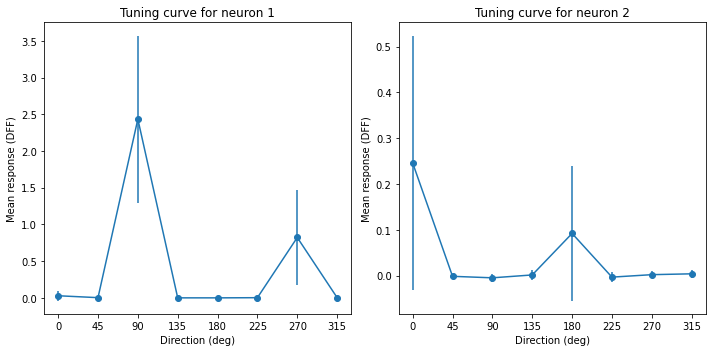

In [33]:
# tuning curve
fig, axs = plt.subplots(1,2, figsize=(10,5))

ax = axs[0]
ax.set_title('Tuning curve for neuron 1')
ax.errorbar(orivals, tuning_tf2, yerr=tuning_std_tf2, fmt='o-')
ax.set_xlabel("Direction (deg)")
ax.set_xticks(range(0,360,45))
ax.set_ylabel("Mean response (DFF)")

ax = axs[1]
ax.set_title('Tuning curve for neuron 2')
ax.errorbar(orivals, tuning2_tf2, yerr=tuning2_std_tf2, fmt='o-')
ax.set_xlabel("Direction (deg)")
ax.set_xticks(range(0,360,45))
ax.set_ylabel("Mean response (DFF)")

fig.tight_layout()

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Discuss** Now based on these two tuning curve, how would you construct heuristic decoding criteria? Can you spculate if there's any benefit of using two neurons instead on just one?
</div>

Now let's set our heuristic decoding

In [ ]:
# decode with 2-cell tuning curves
# cell 1
# if mean DFF>1.3, classify as 90-degree
# if mean 0.2<DFF<1.3, classify as 270-degree
# if mean DFF<0.2, randomly classify as one of the rest
# cell 2
# if mean DFF>0.15, classify as 0-degree
# if mean 0.02<DFF<0.15, classify as 180-degree
# if mean DFF<0.15, randomly classify as one of the rest


fig, axs = plt.subplots(1,2, figsize=(10,5))


ax = axs[0]
ax.set_title('Tuning curve for neuron 1')
ax.errorbar(orivals, tuning_tf2, yerr=tuning_std_tf2, fmt='o-', zorder=0)


# if mean DFF>1.3, classify as 90-degree
ax.scatter(orivals[2], tuning_tf2[2], color='r')
ax.axhline(1.3, ls='--', color='r', 
           label='90: DFF>1.3', zorder=15)

# if mean 0.2<DFF<1.3, classify as 270-degree
ax.scatter(orivals[6], tuning_tf2[6], color='g')
ax.axhline(0.2, ls='--', color='g', 
           label='275: 0.2<DFF<1.3', zorder=10)

# if mean DFF<0.2, randomly classify as one of the rest
ax.scatter(orivals[[0,1,3,4,5,7]], tuning_tf2[[0,1,3,4,5,7]], color='k',
            label='DFF<0.2', zorder=5)
ax.legend()
ax.set_xlabel("Direction (deg)")
ax.set_xticks(range(0,360,45))
ax.set_ylabel("Mean response (DFF)")


ax = axs[1]
ax.set_title('Tuning curve for neuron 2')
ax.errorbar(orivals, tuning2_tf2, yerr=tuning2_std_tf2, fmt='o-', zorder=0)

# if mean DFF>0.15, classify as 0-degree
ax.scatter(orivals[0], tuning2_tf2[0], color='m')
ax.axhline(0.15, ls='--', color='m', 
           label='0: DFF>0.15', zorder=15)

# if mean 0.02<DFF<0.15, classify as 180-degree
ax.scatter(orivals[4], tuning2_tf2[4], color='c')
ax.axhline(0.02, ls='--', color='c', 
           label='180: 0.02<DFF<0.15', zorder=10)
# if mean DFF<0.15, randomly classify as one of the rest
ax.scatter(orivals[[1,2,3,5,6,7]], tuning2_tf2[[1,2,3,5,6,7]], color='k',
            label='DFF<0.15', zorder=5)
ax.legend()
ax.set_xlabel("Direction (deg)")
ax.set_xticks(range(0,360,45))
ax.set_ylabel("Mean response (DFF)")

fig.tight_layout()

With this heuristic decoding, let's first see how it looks on a trial-to-trial basis.

In [ ]:
# plot the trial-to-trial response side by side
# Plot the trial response for the first 15 trials, apply heuristic decoding
num_trials = 15
selected_trial_response_tf2 = response_tf2.trial_response[:num_trials]
selected_trial_response2_tf2 = response2_tf2.trial_response[:num_trials]


fig, axs = plt.subplots(1,2, figsize=(10,5))


ax = axs[0]
ax.set_title('Tuning curve for neuron 1')

# if mean DFF>1.3, classify as 90-degree
ax.axhline(1.3, ls='--', color='r', 
         label='90: DFF>1.3', zorder=15)
ax.plot(selected_trial_response_tf2[selected_trial_response_tf2>=1.3], 
         'o', color='r')

# if mean 0.2<DFF<1.3, classify as 270-degree
ax.axhline(0.2, ls='--', color='g', 
          label='275: 0.2<DFF<1.3', zorder=10)
ax.plot(selected_trial_response_tf2[(selected_trial_response_tf2<1.3) & (selected_trial_response_tf2>=0.2)], 
         'o', color='g')

# if mean DFF<0.2, randomly classify as one of the rest
ax.plot(selected_trial_response_tf2[selected_trial_response_tf2<0.2], 
         'o', color='k', label='DFF<0.2')

ax.set_xlabel("Trial number")
ax.set_ylabel("Mean DFF (%)")
ax.legend()


ax = axs[1]
ax.set_title('Tuning curve for neuron 2')

# if mean DFF>0.15, classify as 0-degree
ax.axhline(0.15, ls='--', color='m', 
         label='0: DFF>0.15', zorder=15)
ax.plot(selected_trial_response2_tf2[selected_trial_response2_tf2>=0.15], 
         'o', color='m')

# if mean 0.02<DFF<0.15, classify as 180-degree
ax.axhline(0.02, ls='--', color='c', 
          label='180: 0.02<DFF<0.15', zorder=10)
ax.plot(selected_trial_response2_tf2[(selected_trial_response2_tf2<0.15) & (selected_trial_response2_tf2>=0.02)], 
         'o', color='c')

# if mean DFF<0.02, randomly classify as one of the rest
ax.plot(selected_trial_response2_tf2[selected_trial_response2_tf2<0.02], 
         'o', color='k', label='DFF<0.02')

ax.set_xlabel("Trial number")
ax.set_ylabel("Mean DFF (%)")
ax.legend()

fig.tight_layout()

Let's implement this heuristic decoding using the tuning curves of the two neurons

In [36]:
# heuristic decoding using the tuning profiles of two neurons
import random

ori_heuristic_2cells = []
for trial_response, trial_response2 in zip(response_tf2.trial_response, response2_tf2.trial_response):
    # cell 1
    if trial_response >= 1.3:
        # if mean DFF>1.3, classify as 90-degree
        # ?
    elif (trial_response < 1.3 and trial_response>=0.2):
        # if mean 0.2<DFF<1.3, classify as 270-degree
        # ?

    elif trial_response2 > 0.15:
        # if mean DFF>0.15, classify as 0-degree
        # ?
    elif (trial_response2 < 0.15 and trial_response2 > 0.02):
        # if mean 0.02<DFF<0.15, classify as 180-degree
        # ?
    else:
        # otherwise, randomly classify as one of the rest
        ori_heuristic_2cells.append(random.choice([45, 135, 225, 315]))
    
ori_heuristic_2cells = np.array(ori_heuristic_2cells)

We can again assess the decoding performance using confusion matrix

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# first drop the nan trials
not_nan_trials_mask = ?
true_orientations = stim_table[stim_table.temporal_frequency==2.0].orientation.values[not_nan_trials_mask]
predicted_orientations_2cells = ori_heuristic_2cells[not_nan_trials_mask]


cm = confusion_matrix(?)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=np.arange(0, 360, 45))
disp.plot()

In [ ]:
# normalized confusion matrix
normalized_cm = cm/ np.sum(cm, axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=normalized_cm, 
                              display_labels=np.arange(0, 360, 45))
disp.plot()

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Discuss** Compare this confusion matrix with the previous one using only cell1. What's the difference? Which one gives better decodability of direction? What does this tell us?
</div>

In [ ]:
# compute decoding accuracy
acc_2cells = ?
acc_2cells

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Discuss** What enables us to better decode the simulus orientation when we use two neurons?
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
What enables us to better decode the simulus orientation when we use two neurons?

1. different response selectivity
2. more samples trial-to-trial neural response variability
</div>

To better understand why using two neurons can improve direction decoding, let's to visualize the responses of 2 neurons in their response space, i.e. each axis of the plot corresponds to the response of one neuron.

In [ ]:
# plot trial-to-trial neuron responses in response space

colors = ['tab:green', 'tab:purple', 'tab:orange', 'tab:olive',
          'tab:blue', 'tab:red', 'tab:brown', 'tab:gray']

stim_table_tf2 = stim_table[stim_table.temporal_frequency==2.0]

plt.figure(figsize=(9,7))
for i, ori in enumerate(orivals):
    ind = stim_table_tf2.orientation[stim_table_tf2.orientation==ori].index
    plt.scatter(
        response_tf2.trial_response[ind].values, 
        response2_tf2.trial_response[ind].values,
        c=colors[i],
        s=24, alpha=0.6,
        label=f'{int(ori)}'
    )

plt.xlabel('neuron 1 response (mean DFF)')
plt.ylabel('neuron 2 response (mean DFF)')
plt.legend()

In [ ]:
# visualize heuristic decoding boundaries in the response space

colors = ['tab:green', 'tab:purple', 'tab:orange', 'tab:olive',
          'tab:blue', 'tab:red', 'tab:brown', 'tab:gray']

stim_table_tf2 = stim_table[stim_table.temporal_frequency==2.0]

plt.figure(figsize=(9,7))
for i, ori in enumerate(orivals):
    ind = stim_table_tf2.orientation[stim_table_tf2.orientation==ori].index
    plt.scatter(
        response_tf2.trial_response[ind].values, 
        response2_tf2.trial_response[ind].values,
        c=colors[i],
        s=24, alpha=0.6,
        label=f'{int(ori)}'
    )

# decision boundaries
plt.axvline(1.3, ls='--', color='r', 
           label='90: n1_DFF>1.3', zorder=15)
plt.axvline(0.2, ls='--', color='g', 
           label='275: 0.2<n1_DFF<1.3', zorder=10)
plt.axhline(0.15, ls='--', color='m', 
           label='0: n2_DFF>0.15', zorder=15)
plt.axhline(0.02, ls='--', color='c', 
           label='180: 0.02<n2_DFF<0.15', zorder=10)

plt.xlabel('neuron 1 response (mean DFF)')
plt.ylabel('neuron 2 response (mean DFF)')
plt.legend()

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Discuss** What does the above plot tell us how to decode the stimulus orientation from the responses of 2 neurons? In principle, how can we better partition the 2-cell response space for better decoding stimulus direction?
</div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Discuss** What does this imply if we use even more neurons to decode?
</div>